# Evaluación de la 'caminabilidad' y accesibilidad para las principales colonias en la Ciudad de México 

La accesibilidad y transitabilidad peatonal de las ciudades puede ser evaluada a partir de la facilidad con la que se puede acceder a amenidades tales como escuelas, restaurantes, parques, comercios, etc. El siguiente script realiza una descarga de puntos de interés (POIs: restaurantes, escuelas y bares) y la red de calles de la base de datos de OpenStreetMap para 3 Delegaciones de la Ciudad de México (Cuauhtémoc, Miguel Hidalgo y Benito Juárez) compuestas por 163 colonias. Después calcula y grafica la distancia de cada nodo de la red de calles a la amenidad más cercana. Para visualizar y ejecutar esta libreta de códgigo (IPython Notebook) es recomendable instalar la distribución de Python 'Anaconda' que incluye Jupyter Notebook. Asimismo es necesario instalar los siguientes elementos: 

  - [Pandana (V 0.2)](https://udst.github.io/pandana/installation.html) librería para análisis de redes (solo funciona con Python 2.7)
  - [Anaconda para Python 2.7](https://www.continuum.io/downloads) Plataforma para Ciencia de Datos
  - [Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/users/installing.html) librería para visualizaciones geográficas en 2D

Este script es una adaptación del código de Geoff Boing: [Visualize Urban Accessibility and Walkability](http://geoffboeing.com/2016/07/visualize-urban-accessibility-walkability/)
 

In [2]:
# cargar los elementos necesarios para el análisis
import pandana, time, os, pandas as pd, numpy as np
from pandana.loaders import osm
%matplotlib inline

## 1. Configuración del Script

In [3]:
# configurar la búsqueda a un máximo de 1 kilómetro para los 10 POIs más cercanos
amenities = ['restaurant', 'bar', 'school']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #len: largo -número de elementos- uno por amenidad más uno para combinarlos

# caja de búsqueda -bounding box- lista de coorenadas latidud de esquina inferior izquierda -llcrnrlat-, longitud de esquina inferior izquierda -llcrnrlng-, latitud de esquina superior derecha -urcrnrlat-, longitud de esquina superior derecha -urcrnrlng-
bbox = [19.3526108944, -99.2161560059, 19.4439318562, -99.1231155396] #lat-long para las 3 delegaciones de CDMX

In [4]:
# configurar los nombres de archivos para crear y guardar los juegos de datos de POIs y la red de calles
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)
poi_filename = 'data/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [5]:
# argumentos clave a definir para el gráfico en matplotlib
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# argumentos clave a definir para los gráficos de dispersión -scatterplots-
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# argumentos clave a definir para los gráficos de agregación de redes
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# argumento clave a definir para el mapa de hexágonos
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# argumento a definir para la leyenda de gradiente de color
cbar_kwargs = {}

# argumento a definir para el mapa base
bmap_kwargs = {}

# color del fondo del eje
bgcolor = 'k'

## 2. Descarga de POIs y la Red de Calles desde OSM

Obtener los puntos de interés a través de dos alternativas A) cargar un juego de datos existente desde un CSV o B) Extraerlo desde la API de OpenStreetMap con los parámetros definidos en el paso 1.

In [6]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # si existe un archivo con POIs cargar el juego de datos desde ahí
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # de otra manera, hacer una llamada a la API de OSM 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)
    
    # Guardar a CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()

770 POIs downloaded from OSM in 1.48 seconds


,amenity,name,lat,lon
id,,,,
326541824,school,NaN,19.373987,-99.185795
326552536,restaurant,California,19.374085,-99.179259
326566947,school,Simón Bolivar,19.370860,-99.184479
331418533,restaurant,La Estación,19.388517,-99.190950
331599320,restaurant,Taquería La Onda,19.427638,-99.211661


In [7]:
# Revisar cuantos POIs se extrajeron por tipo
pois['amenity'].value_counts()

restaurant    637
school         68
bar            65
Name: amenity, dtype: int64

Extraer la Red de Calles por dos alternativas A) cargar un juego de datos existente desde un archivo HDF5 (modelo de datos y formato de archivo jerárquico) o B) obtenerlo desde la API de OSM.

In [8]:
start_time = time.time()
if os.path.isfile(net_filename):
    # si una red de calles existe, cargar el juego de datos desde ahí
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # de otra manera, consultar a la API de OSM
    network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identificar los nodos con menos conexiones que 10 dada una distancia de 1 kilómetro
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remover nodos de baja conectividad y guradar en HDF5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 15,337 nodes downloaded from OSM in 35.57 secs


Al guardar una red a HDF5 es posible excluir ciertos nodos. Esto puede resultar útil para refinar una red que contenga solo nodos validados.

## 3. Calcular la accesibilidad para todas las amenidades

In [9]:
# precalcula el rango de las consultas (los nodos que se pueden alcanzar con la distancia máxima definida)
# mientras se utilice una distancia menor a esta, se utilizaran los resultados en cache
network.precompute(distance + 1)

In [10]:
# iniciar el motor C++ de POIs
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [11]:
# iniciar una categoría para todas las amenidades con ubicación definida por lat-long
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

In [12]:
# buscar el n número de amenidades cercanas para cada nodo en la red
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# regresa una matriz de distancias con tantas columnas como número de POIs solicitados
# cada celda representa la distancias entre el nodo y cada n de POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

15,337 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
30339493,400.432007,734.906006,827.783020,827.783020,846.190979,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
30339495,642.562988,842.526978,943.528992,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
30339671,0.000000,187.285004,276.600006,276.859985,385.416992,510.846008,519.723999,520.732971,601.614990,648.377014
30339672,0.000000,89.574997,96.703003,187.285004,505.023987,523.718994,572.702026,585.458008,613.543030,632.109009
30339673,86.614998,176.190002,272.893005,363.475006,437.352997,455.919006,455.919006,639.289978,657.984985,716.534973


## 4. Graficar la accesibilidad de cada nodo a todas las amenidades

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


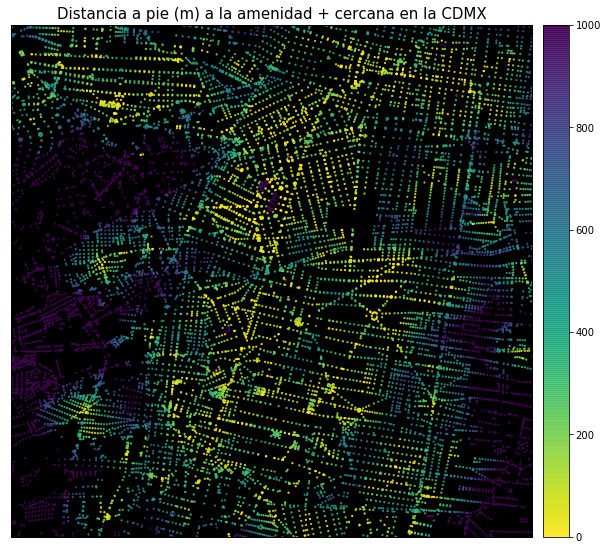

In [14]:
# distancia a la amenidad más cercana de cualquier tipo
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) a la amenidad + cercana en la CDMX', fontsize=15)
fig.savefig('images/accesibilidad-todos-CDMX.png', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


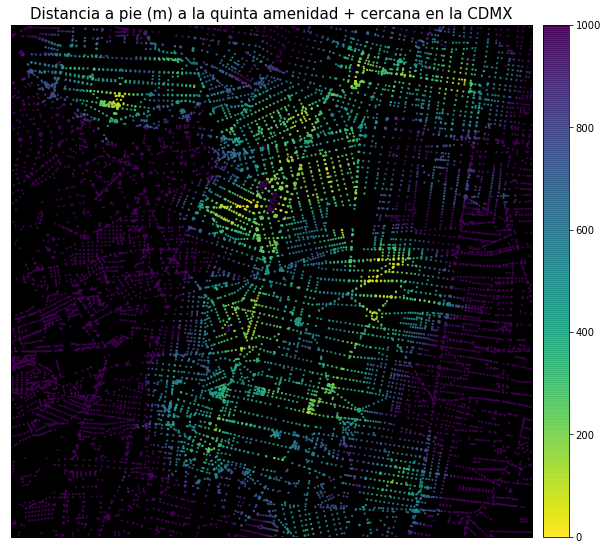

In [16]:
# distancia a la 5a amenidad más cercana
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) a la quinta amenidad + cercana en la CDMX', fontsize=15)
fig.savefig('images/accessibilidad-todos-5a-CDMX.png', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3459: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3472: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


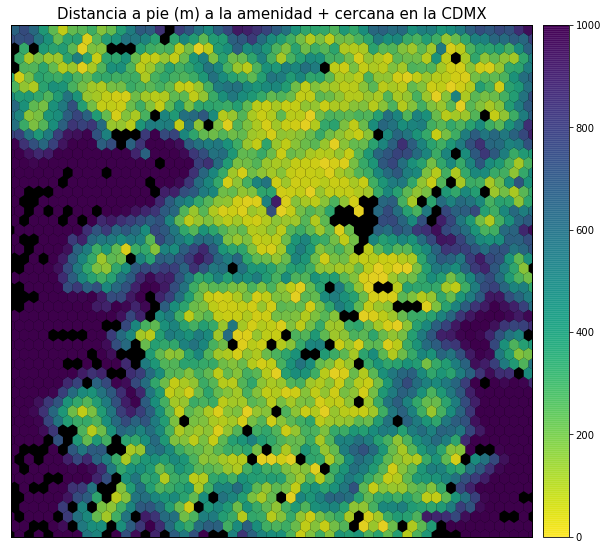

In [17]:
# distancia a la amenidad más cercana, visualizado con hexabins
bmap, fig, ax = network.plot(all_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) a la amenidad + cercana en la CDMX', fontsize=15)
fig.savefig('images/accesibilidad-hexbin-CDMX.png', dpi=200, bbox_inches='tight')

## 5. Calcular y graficar la accesibilidad independiente para cada tipo de amenidad

Los tipos de amenidades que se especificaron originalmente son: restaurantes, bares y escuelas

In [18]:
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


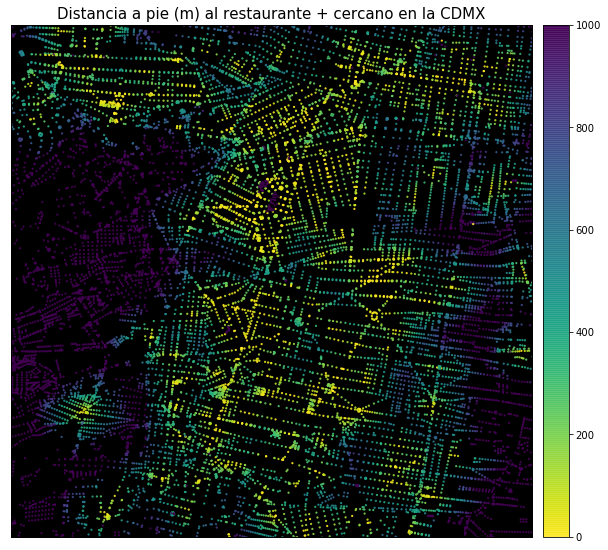

In [19]:
# distancia al restaurante más cercano
restaurant_access = network.nearest_pois(distance=distance, category='restaurant', num_pois=num_pois)
bmap, fig, ax = network.plot(restaurant_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) al restaurante + cercano en la CDMX', fontsize=15)
fig.savefig('images/accesibilidad-restaurante-CDMX.png', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


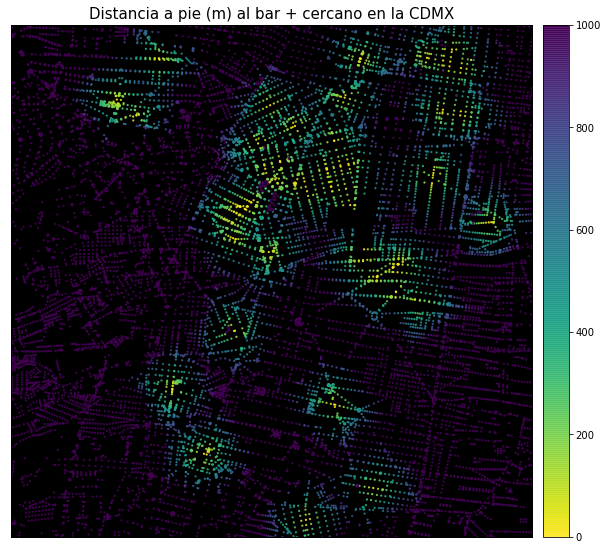

In [20]:
# distancia al bar más cercano
bar_access = network.nearest_pois(distance=distance, category='bar', num_pois=num_pois)
bmap, fig, ax = network.plot(bar_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) al bar + cercano en la CDMX', fontsize=15)
fig.savefig('images/accesibilidad-bar-CDMX.png', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


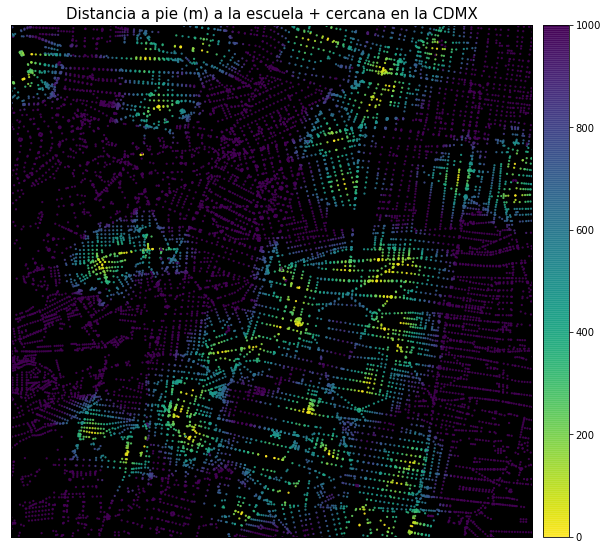

In [21]:
# distancia a la escuela más cercana
school_access = network.nearest_pois(distance=distance, category='school', num_pois=num_pois)
bmap, fig, ax = network.plot(school_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)
ax.set_title('Distancia a pie (m) a la escuela + cercana en la CDMX', fontsize=15)
fig.savefig('images/accesibilidad-escuela-CDMX.png', dpi=200, bbox_inches='tight')

## 6. Consultas a la Red de Agregación

Se pueden visualizar otras variables de la red a partir de consultas. En este caso se utiliza la capacidad de los comercios que se puede obtener directamente de OSM. Idealmente este tipo de análisis se realizaria con valores de población o áreas en metros cuadrados.

In [22]:
# obtener el identificador del nodo más cercano -node_id- para cada POI
pois['node_ids'] = network.get_node_ids(pois['lon'], pois['lat'])

In [23]:
# asignar el valor de capacidad correspondiente a cada nodo
network.set(pois['node_ids'], variable=pois['capacity'], name='capacity')

Removed 762 rows because they contain missing values


In [24]:
# sumar la capacidad con disminusión lineal -linear decay- a lo largo de la distancia determinada
capacity_sum = network.aggregate(distance=distance, type='sum', decay='linear', name='capacity')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


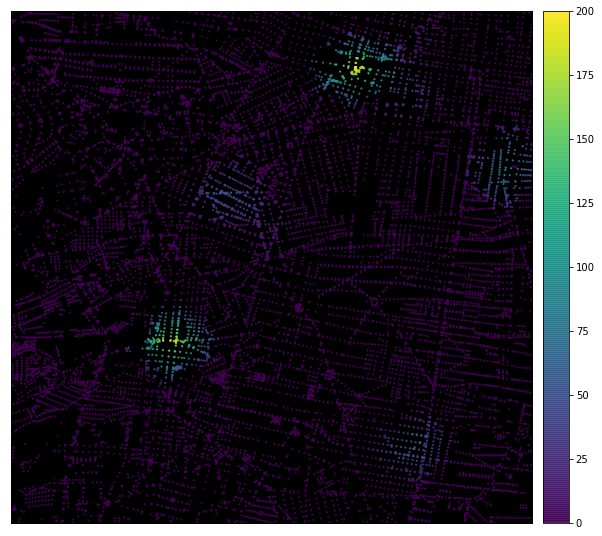

In [25]:
# graficar la accesibilidad a los espacios con más capacidad
bmap, fig, ax = network.plot(capacity_sum, bbox=bbox, plot_type='scatter', plot_kwargs=agg_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)